# 2차모델 : Prophet 
## 시계열모델중 유명한 모델이라고 생각해서 사용했고
## 평가지표중에 MAE를 선정해서 최적파라미터를 정했고,
## 최종 실행 셀만 돌려서 결과값 도출하였습니다
## 데이터는 토요일 기준으로 짤라서 직전 주까지의 데이터를 가져오고
## 모델을 돌리는 시점의 다음주 출고량을 예측하게됩니다
## holiday 요소는 각 제품별로 추세 시각화를 한 후에
## 명절에 가장 영향을 많이 받았다고 판단되는 기간을 임의로 판단하여 설정했어요
## holiday만 잘 조절한다면 더 높은 정확도를 보여줄 수 있다고 생각합니다

## https://hyperconnect.github.io/2020/03/09/prophet-package.html


# 파라미터 도출을 위한 코드
### EX 제품 : 곰탕육수(구.나주곰탕육수)

In [1]:
import pandas as pd
import pymssql
import numpy as np
from prophet import Prophet 
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from datetime import datetime 
from datetime import timedelta

#### timelist : cutoff 10개의 가장 최근 일자값 , cutoff 생성을 위한 변수
#### holiday : 시즌영향이 있는 일자들을 넣어서 가중치를 넣어주는 변수, 
#### 여기에 들어가는 일자들이 모두 비슷한 정도의 영향을 받는 일자여야 함으로 설과 추석만 넣어줌
#### 각 제품별로 추세시각화 해보고 가장 튀었다 싶은 시즌을 정함 (ex 설 1주전, 추석2주전)
#### cutoff : 총 10개 설정, 모델 성과지표 도출을 위한 데이터셋 자르는 시점 
#### horizon : 예측할 구간

In [2]:
connet = pymssql.connect(server = '121.134.7.213',user='sa',password='twinet3015!', database='SEIERP_IYN_BAK')

sql_query = '''
declare	 @CD_CORP         NVARCHAR(2)
  , @DT_DEL_F        NVARCHAR(8)
  , @DT_DEL_T        NVARCHAR(8)

set @CD_CORP	=	'01'
set	@DT_DEL_F	=	'20200101'
set @DT_DEL_T	=	(SELECT	CONVERT(CHAR(8), GETDATE(), 112))

    SET NOCOUNT ON
	SET ANSI_WARNINGS OFF
	SET ARITHIGNORE ON
	SET ARITHABORT OFF

;With DeliveryCross AS (
 select a.CD_EMP
 , dbo.GetFormat_Day(B.DT_COMP,'-') as DT_COMP
 , B.NO_SMDL, B.NO_SMDLSUB
 , B.QT_SMDL, B.UP_PRICE, B.AM_PRICE, B.AM_VAT, B.AM_TOT, B.TX_NOTE, B.NO_SMOR
 , c.NM_CUST as NM_DELCUST
 , k.NM_USER, r.NM_WAREHOUSE
 , i.CD_ITEM, i.NM_ITEM, i.TX_SPEC, n.NM_TYPEDTL as NM_UNIT
 FROM SMDL_DELIVERY_H a
 Left outer Join SMDL_DELIVERY_D as b on a.CD_CORP=b.CD_CORP and a.NO_SMDL=b.NO_SMDL
 Left outer Join BSCT_CUST c on b.CD_CORP=c.CD_CORP and b.CD_DELCUST=c.CD_CUST
 Left outer Join BSIN_USER k on a.CD_CORP=k.CD_CORP and a.CD_EMP=k.CD_EMP
 Left outer Join STIT_WAREHOUSE r on b.CD_CORP=r.CD_CORP and b.CD_WAREHOUSE=r.CD_WAREHOUSE		--창고코드
 Left outer Join BSIT_ITEM i on b.CD_CORP=i.CD_CORP and b.CD_SYSITEM=i.CD_SYSITEM				--	품목코드
 Left outer Join (select * from BSIN_CODE_DTL) n on i.CD_CORP=n.CD_CORP and i.CD_UNIT=n.CD_TYPEDTL And n.CD_TYPE='MI001'
 Left outer Join (Select * From BSIN_CODE_DTL) t1 on b.CD_CORP=t1.CD_CORP and b.CD_SELLTYPE=t1.CD_TYPEDTL and t1.CD_TYPE='SM004'
 Left outer Join FROP_STORE m On c.CD_CORP = m.CD_CORP AND c.CD_STORECODE = m.CD_STORE			--매장코드
 WHERE 1=1
       AND A.CD_CORP    = @CD_CORP
	   AND a.DT_COMP	>=	@DT_DEL_F 
	   AND a.DT_COMP	<=	@DT_DEL_T
       AND ISNULL(B.CK_BUY, 0) <> 9			--공장출고만
 )
 SELECT 1 div_out, DT_COMP, CD_ITEM, NM_ITEM , TX_SPEC , NM_UNIT
 , sum(QT_SMDL) QT_SMDL, ((sum(AM_PRICE)) / sum(QT_SMDL)) UP_PRICE --avg(UP_PRICE) UP_PRICE
 , sum(AM_VAT) AM_VAT, sum(AM_PRICE) AM_PRICE, sum(AM_PRICE)+sum(AM_VAT) AM_TOT
 FROM DeliveryCross
 GROUP BY CD_ITEM, NM_ITEM  , TX_SPEC , NM_UNIT, DT_COMP
 UNION ALL
 SELECT 2 div_out, '', '총계' itemcode1, '' itemname , '' ,''
 , sum(QT_SMDL) QT_SMDL, ((sum(AM_PRICE)) / sum(QT_SMDL)) UP_PRICE  --, avg(UP_PRICE) UP_PRICE
 , sum(AM_VAT) AM_VAT, sum(AM_PRICE) AM_PRICE, sum(AM_PRICE)+sum(AM_VAT) AM_TOT
 FROM DeliveryCross
 order by div_out, CD_ITEM
 '''
row_data = pd.read_sql(sql=sql_query,con=connet)

df1 = row_data[row_data['NM_ITEM']=='곰탕육수(구.나주곰탕육수)'][['DT_COMP','QT_SMDL']]
df1.columns = ['ds','y']
df1['ds'] = pd.to_datetime(df1['ds'])
df1.set_index(df1['ds'],inplace = True)
df2 = df1.resample('D').sum()
df3 = df2.reset_index()
while (df3['ds'].iloc[len(df3)-1].weekday() != 5 ):
    df3 = df3.drop(len(df3)-1,axis=0)
df3['index'] = df3['ds']
df3.set_index(df3['index'],inplace = True)
df4 = df3.drop(['index'],axis=1)
week_df = df4.resample('W-Sat').sum()
week_df['ds'] = week_df.index
data = week_df.reset_index()
data1 = data.drop(['index'],axis=1) 

holiday = pd.DataFrame({
    'holiday':'holiday',
    'ds' : pd.concat([
        pd.Series(pd.date_range('2020-01-12','2020-01-18',freq='D')),
        pd.Series(pd.date_range('2020-09-17','2020-09-23',freq='D')),
        pd.Series(pd.date_range('2023-01-02','2023-01-08',freq='D')),
        pd.Series(pd.date_range('2021-09-08','2021-09-14',freq='D')),
        pd.Series(pd.date_range('2021-01-30','2021-02-05',freq='D')),
        pd.Series(pd.date_range('2022-01-19','2022-02-25',freq='D')),
        pd.Series(pd.date_range('2022-08-28','2022-09-03',freq='D'))
    ])
})

timelist = ['2022-01-14']
for i in range(10):
    timelist.append(pd.to_datetime(timelist[len(timelist)-1]) - timedelta(weeks=1))
timelist
a = pd.to_datetime(timelist)
cutoffs = a.sort_values()

para_grid = {
    'changepoint_prior_scale' : [0.001,0.01,0.1,0.5],
    'seasonality_prior_scale' : [0.01,0.1,1,5,10],
    'holidays_prior_scale' : [0.01,0.1,1,5,10],
    'changepoint_range' : [0.8,0.9,0.95]
}
parameters = [dict(zip(para_grid.keys(),v))
              for v in itertools.product(*para_grid.values())]

diff_1 = []
diff_2 = []
mae = []
for p in parameters:
    model = Prophet(**p, holidays=holiday).fit(data1)
    df_cv = cross_validation(model,cutoffs = cutoffs,
                             horizon='14 days',parallel="processes")
    diff_1.append(abs(df_cv['yhat'].iloc[20] - df_cv['y'].iloc[20]))
    diff_2.append(abs(df_cv['yhat'].iloc[21] - df_cv['y'].iloc[21]))
    df_p = performance_metrics(df_cv, rolling_window=1/2)
    mae.append(df_p['mae'].iloc[1]) # 2주치값을 중요하게

result = pd.DataFrame(parameters)
result['diff_1'] = diff_1
result['diff_2'] = diff_2
result['mae'] = mae
result.sort_values('mae')
result

C:\Users\ioi\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
11:53:26 - cmdstanpy - INFO - Chain [1] start processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
11:53:26 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:45 - cmdstanpy - INFO - Chain [

11:58:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
11:58:08 - cmdstanpy - INFO - Chain [1] start processing
11:58:08 - cmdstanpy - INFO - Chain [1] done processing
11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:21 - cmdstanpy - INFO - Chain [1] done processing
11:58:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing
11:58:40 - cmdstanpy - INFO - Chain [1] start processing
11:58:41 - cmdstanpy - INFO - Chain [1] done processing
11:58:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
11:58:41 - cmdstanpy - INFO - Chain [1] start processing
11:58:41 - cmdstanpy - INFO - Chain [1] done processi

Optimization terminated abnormally. Falling back to Newton.
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:40 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:37 - cmdstanpy - INFO - Chain [1] start processing
12:07:37 - cmdstanpy - INF

12:14:16 - cmdstanpy - INFO - Chain [1] start processing
12:14:16 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:29 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:57 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - ERROR -

12:24:52 - cmdstanpy - INFO - Chain [1] start processing
12:24:53 - cmdstanpy - INFO - Chain [1] done processing
12:25:03 - cmdstanpy - INFO - Chain [1] start processing
12:25:03 - cmdstanpy - INFO - Chain [1] done processing
12:25:16 - cmdstanpy - INFO - Chain [1] start processing
12:25:16 - cmdstanpy - INFO - Chain [1] done processing
12:25:28 - cmdstanpy - INFO - Chain [1] start processing
12:25:28 - cmdstanpy - INFO - Chain [1] done processing
12:25:41 - cmdstanpy - INFO - Chain [1] start processing
12:25:41 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing
12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing
12:26:22 - cmdstanpy - INFO - Chain [1] start processing
12:26:22 - cmdstanpy - INFO - Chain [1]

12:38:05 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:39:06 - cmdstanpy - INFO - Chain [1] start processing
12:39:06 - cmdstanpy - INFO - Chain [1] done processing
12:39:16 - cmdstanpy - INFO - Chain [1] start processing
12:39:16 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:26 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] 

12:51:29 - cmdstanpy - INFO - Chain [1] done processing
12:51:53 - cmdstanpy - INFO - Chain [1] start processing
12:51:53 - cmdstanpy - INFO - Chain [1] done processing
12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:08 - cmdstanpy - INFO - Chain [1] done processing
12:52:24 - cmdstanpy - INFO - Chain [1] start processing
12:52:24 - cmdstanpy - INFO - Chain [1] done processing
12:52:41 - cmdstanpy - INFO - Chain [1] start processing
12:52:41 - cmdstanpy - INFO - Chain [1] done processing
12:52:56 - cmdstanpy - INFO - Chain [1] start processing
12:52:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:13 - cmdstanpy - INFO - Chain [1] start processing
12:53:13 - cmdstanpy - INFO - Chain [1] done processing
12:53:29 - cmdstanpy - INFO - Chain [1] start processing
12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:45 - cmdstanpy - INFO - Chain [1] start processing
12:53:45 - cmdstanpy - INFO - Chain [1] done processing
12:54:01 - cmdstanpy - INFO - Chain [1] 

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,diff_1,diff_2,mae
0,0.001,0.01,0.01,0.80,5.372987,19.568513,28.769003
1,0.001,0.01,0.01,0.90,5.497091,19.450525,28.575880
2,0.001,0.01,0.01,0.95,5.562170,19.389277,28.808592
3,0.001,0.01,0.10,0.80,5.956548,35.533763,30.518737
4,0.001,0.01,0.10,0.90,5.772900,35.798542,30.580547
...,...,...,...,...,...,...,...
295,0.500,10.00,5.00,0.90,3.188524,41.641681,28.053875
296,0.500,10.00,5.00,0.95,3.184065,41.645499,28.094002
297,0.500,10.00,10.00,0.80,3.193323,41.645299,28.179477
298,0.500,10.00,10.00,0.90,3.194055,41.645610,28.111694


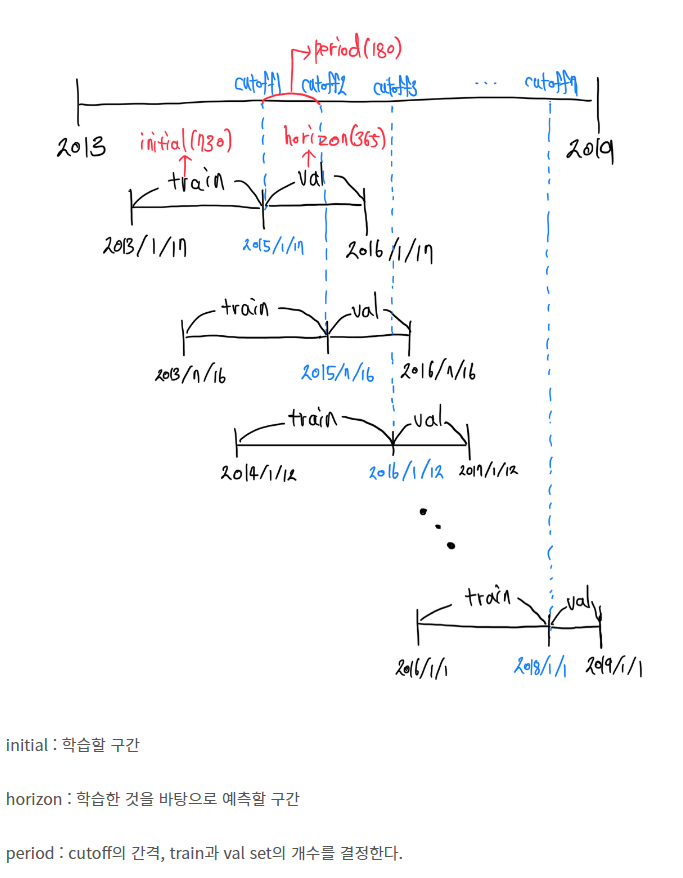

In [8]:
from IPython.display import Image
Image('C:\\Users\\ioi\\Desktop\\제목 없음.png')

## 제품별로 최적 파라미터 넣은 엑셀 작성

In [8]:
df_para = pd.read_excel('C:\\Users\\ioi\\Desktop\\시계열\\자동화 프로그램\\파라미터.xlsx')
df_para

,품명,법인,4차 평가,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,휴일 유무,휴일 종류
0,한촌탕고기(뒷덩이),이연,o,0.010,10.00,0.10,0.95,hol_2su1_2chu,설(2주전)추석(2주전)
1,한촌수육양지,이연,o,0.500,0.01,0.01,0.80,hol_no,x
2,한촌설렁탕육수(2.5kg),이연,O,0.010,0.01,0.10,0.80,hol_2su1_2chu,설 추석 2주전
3,삶은소건(2kg),이연,O,0.010,0.01,0.10,0.90,hol_no,x
4,사골추출액-1202(냉장),이연,o,0.500,0.01,0.10,0.95,hol_1sul,설날(일주일)
5,한촌매운돼지갈비소스,이연,o,0.010,0.01,10.00,0.80,hol_1sul_1chu,설 추석 1주일
6,한촌양념불고기,이연,o,0.100,0.10,5.00,0.90,hol_1sul_1chu,NaN
7,곰탕육수(구.나주곰탕육수),이연,o,0.100,0.01,0.01,0.80,hol_2su1_2chu,설 추석 2주전
8,혼합김치 18Kg,이연,o,0.500,0.01,0.10,0.80,hol_no,x
9,한촌탕고기(삶은소고기),이연,o,0.001,5.00,5.00,0.90,hol_no,x


## 모델 실행 코드

#### 휴일설정 : sul = 설 , chu = 추석 , 숫자는 n주전

In [9]:
hol_no = pd.DataFrame(columns=['holiday','ds'])

hol_1sul_1chu = pd.DataFrame({
    'holiday':'holiday',
    'ds' : pd.concat([
        pd.Series(pd.date_range('2020-01-19','2020-01-25',freq='D')),
        pd.Series(pd.date_range('2020-09-24','2020-09-30',freq='D')),
        pd.Series(pd.date_range('2021-09-15','2021-09-21',freq='D')),
        pd.Series(pd.date_range('2021-02-06','2021-02-12',freq='D')),
        pd.Series(pd.date_range('2022-01-26','2022-02-01',freq='D')),
        pd.Series(pd.date_range('2022-09-04','2022-09-10',freq='D')),
        pd.Series(pd.date_range('2023-01-16','2023-01-22',freq='D')),
        pd.Series(pd.date_range('2023-09-23','2023-09-29',freq='D'))
    ])
})
hol_2su1_2chu = pd.DataFrame({
    'holiday':'holiday',
    'ds' : pd.concat([
        pd.Series(pd.date_range('2020-01-12','2020-01-18',freq='D')),
        pd.Series(pd.date_range('2020-09-17','2020-09-23',freq='D')),
        pd.Series(pd.date_range('2021-09-08','2021-09-14',freq='D')),
        pd.Series(pd.date_range('2021-01-30','2021-02-05',freq='D')),
        pd.Series(pd.date_range('2022-01-19','2022-02-25',freq='D')),
        pd.Series(pd.date_range('2022-08-28','2022-09-03',freq='D')),
        pd.Series(pd.date_range('2023-01-09','2023-01-15',freq='D')),
        pd.Series(pd.date_range('2023-09-16','2023-09-22',freq='D'))
    ])
})
hol_1sul = pd.DataFrame({
    'holiday':'holiday',
    'ds' : pd.concat([
        pd.Series(pd.date_range('2020-01-19','2020-01-25',freq='D')),
        pd.Series(pd.date_range('2021-02-06','2021-02-12',freq='D')),
        pd.Series(pd.date_range('2022-01-26','2022-02-01',freq='D')),
        pd.Series(pd.date_range('2023-01-16','2023-01-22',freq='D'))
    ])
})

holiday = {
    'hol_no' : hol_no,
    'hol_1sul_1chu' : hol_1sul_1chu,
    'hol_2su1_2chu' : hol_2su1_2chu,
    'hol_1sul' : hol_1sul
    
}
item_name = df_para['품명'].to_list()
result = pd.DataFrame(columns= ['품명','품목코드','날짜','수량'])

for i in range(len(item_name)) :
    df1 = row_data[row_data['NM_ITEM']==item_name[i]][['DT_COMP','QT_SMDL']]
    df1.columns = ['ds','y']
    df1['ds'] = pd.to_datetime(df1['ds'])
    df1.set_index(df1['ds'],inplace = True)
    df2 = df1.resample('D').sum()
    df3 = df2.reset_index()
    while (df3['ds'].iloc[len(df3)-1].weekday() != 5 ):
        df3 = df3.drop(len(df3)-1,axis=0)

    df3['index'] = df3['ds']
    df3.set_index(df3['index'],inplace = True)
    df4 = df3.drop(['index'],axis=1)

    week_df = df4.resample('W-Sat').sum()
    week_df['ds'] = week_df.index
    data = week_df.reset_index()
    data1 = data.drop(['index'],axis=1)    

    m = Prophet(holidays=
            holiday[df_para[df_para['품명']==item_name[i]]['휴일 유무'].values.sum()],
        changepoint_prior_scale=
                df_para[df_para['품명']==item_name[i]]['changepoint_prior_scale'].sum(),
       seasonality_prior_scale=
                df_para[df_para['품명']==item_name[i]]['seasonality_prior_scale'].sum(),
       holidays_prior_scale=
                df_para[df_para['품명']==item_name[i]]['holidays_prior_scale'].sum(),
       changepoint_range=
               df_para[df_para['품명']==item_name[i]]['changepoint_range'].sum()).fit(data1)
    future = m.make_future_dataframe(periods=2,freq='W-sat')
    forecast = m.predict(future)
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(1)
    result.loc[len(result)] = [item_name[i],
                               row_data[row_data['NM_ITEM']==item_name[i]]['CD_ITEM'].iloc[0],
                               forecast['ds'].iloc[len(forecast)-1] ,
                               round(forecast['yhat'].iloc[len(forecast)-1])]
result

16:01:31 - cmdstanpy - INFO - Chain [1] start processing
16:01:31 - cmdstanpy - INFO - Chain [1] done processing
16:01:32 - cmdstanpy - INFO - Chain [1] start processing
16:01:32 - cmdstanpy - INFO - Chain [1] done processing
16:01:32 - cmdstanpy - INFO - Chain [1] start processing
16:01:32 - cmdstanpy - INFO - Chain [1] done processing
16:01:33 - cmdstanpy - INFO - Chain [1] start processing
16:01:33 - cmdstanpy - INFO - Chain [1] done processing
16:01:33 - cmdstanpy - INFO - Chain [1] start processing
16:01:34 - cmdstanpy - INFO - Chain [1] done processing
16:01:34 - cmdstanpy - INFO - Chain [1] start processing
16:01:34 - cmdstanpy - INFO - Chain [1] done processing
16:01:35 - cmdstanpy - INFO - Chain [1] start processing
16:01:35 - cmdstanpy - INFO - Chain [1] done processing
16:01:35 - cmdstanpy - INFO - Chain [1] start processing
16:01:35 - cmdstanpy - INFO - Chain [1] done processing
16:01:36 - cmdstanpy - INFO - Chain [1] start processing
16:01:36 - cmdstanpy - INFO - Chain [1]

,품명,품목코드,날짜,수량
0,한촌탕고기(뒷덩이),A01010303,2023-03-04,84
1,한촌수육양지,A01010201,2023-03-04,189
2,한촌설렁탕육수(2.5kg),A01030104,2023-03-04,9188
3,삶은소건(2kg),A01010404,2023-03-04,141
4,사골추출액-1202(냉장),A01030203,2023-03-04,1011
5,한촌매운돼지갈비소스,A01080101,2023-03-04,122
6,한촌양념불고기,A01020301,2023-03-04,493
7,곰탕육수(구.나주곰탕육수),A01031101,2023-03-04,180
8,혼합김치 18Kg,G01010101,2023-03-04,912
9,한촌탕고기(삶은소고기),A01010308,2023-03-04,3326
